In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from copy import deepcopy
from collections import deque
from glob import glob
from io import StringIO, BytesIO
import json
from functools import partial


from scipy.spatial import cKDTree
import h5py
import k3d
import yaml
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pymesh
import torch
import trimesh.transformations as tt
import trimesh
import xml.etree.ElementTree as ET

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-vdmckkog because the default path (/home/user/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
import os
os.environ['OMP_NUM_THREADS'] = '8'

In [33]:
def display_sharpness(mesh=None, plot_meshvert=True,
                      samples=None, samples_distances=None,
                      sharp_vert=None, sharp_curves=None,
                      directions=None, directions_width=0.0025,
                      samples_color=0x0000ff, samples_psize=0.002, 
                      mesh_color=0xbbbbbb, meshvert_color=0x666666, meshvert_psize=0.0025,
                      sharpvert_color=0xff0000, sharpvert_psize=0.0025,
                      sharpcurve_color=None, sharpcurve_width=0.0025,
                      as_image=False, plot_height=768,
                      cmap=k3d.colormaps.matplotlib_color_maps.coolwarm_r,
                      max_dist=1.0):
    
    plot = k3d.plot(height=plot_height)
    
    if None is not mesh:
        k3d_mesh = k3d.mesh(mesh.vertices, mesh.faces, color=mesh_color)
        plot += k3d_mesh

        if plot_meshvert:
            k3d_points = k3d.points(mesh.vertices, 
                                    point_size=meshvert_psize, color=meshvert_color)
            plot += k3d_points
            k3d_points.shader='flat'

    if None is not samples:
        colors = None
        if None is not samples_distances:
            colors = k3d.helpers.map_colors(
                samples_distances, cmap, [0, max_dist]
            ).astype(np.uint32)
            k3d_points = k3d.points(samples, point_size=samples_psize, colors=colors)
        else:
            if samples_color == 'z':
                v = -np.array([0., 0., 1.])
                max_dist = np.max(np.dot(samples, v))
                min_dist = np.min(np.dot(samples, v))
                colors = k3d.helpers.map_colors(
                    np.dot(samples, v), k3d.colormaps.matplotlib_color_maps.viridis, [min_dist, max_dist]
                ).astype(np.uint32)
                k3d_points = k3d.points(samples, point_size=samples_psize, colors=colors)
                
            else:
                k3d_points = k3d.points(samples, point_size=samples_psize, color=samples_color)
                
        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not directions:
            vectors = k3d.vectors(
                samples,
                directions * samples_distances[..., np.newaxis],
                use_head=False, 
                line_width=directions_width)
            print(vectors)
            plot += vectors

#             directions_to_plot = np.hstack((samples, samples + directions))
            
#             for i, dir_to_plot in enumerate(directions_to_plot):
#                 dir_to_plot = dir_to_plot.reshape((2, 3))
#                 if np.all(dir_to_plot[0] == dir_to_plot[1]):
#                     continue
#                 color = int(colors[i]) if None is not colors else samples_color
#                 plt_line = k3d.line(dir_to_plot, 
#                                     shader='mesh', width=directions_width, color=color)
#                 plot += plt_line

    if None is not sharp_vert:
        k3d_points = k3d.points(sharp_vert,
                                point_size=sharpvert_psize, color=sharpvert_color)
        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not sharp_curves:            
            if None is not sharpcurve_color:
                color = sharpcurve_color
            else:
                import randomcolor
                rand_color = randomcolor.RandomColor()
            for i, vert_ind in enumerate(sharp_curves):
                sharp_points_curve = mesh.vertices[vert_ind]
                
                if None is sharpcurve_color:
                    color = rand_color.generate(hue='red')[0]
                    color = int('0x' + color[1:], 16)
                plt_line = k3d.line(sharp_points_curve, 
                                    shader='mesh', width=sharpcurve_width, color=color)
                plot += plt_line
        
    plot.grid_visible = False
    plot.display()
    
    if as_image:
        plot.fetch_screenshot()
        return Image(data=b64decode(plot.screenshot))

In [5]:
# mm/pixel
HIGH_RES = 0.02
MED_RES = 0.05
LOW_RES = 0.125
XLOW_RES = 0.25

## 1. Working with point patches

In [6]:
from sharpf.data import DataGenerationException
from sharpf.utils.abc_utils.abc.abc_data import ABCModality, ABCChunk, ABC_7Z_FILEMASK
from sharpf.data.annotation import ANNOTATOR_BY_TYPE
from sharpf.data.camera_pose_manager import POSE_MANAGER_BY_TYPE
from sharpf.data.imaging import IMAGING_BY_TYPE
from sharpf.data.noisers import NOISE_BY_TYPE
from sharpf.utils.abc_utils.abc import feature_utils
from sharpf.utils.py_utils.console import eprint_t
from sharpf.utils.py_utils.os import add_suffix
from sharpf.utils.py_utils.config import load_func_from_config
from sharpf.utils.abc_utils.mesh.io import trimesh_load
from sharpf.utils.plotting import display_depth_sharpness
from sharpf.utils.camera_utils.camera_pose import camera_to_display, CameraPose
from sharpf.utils.abc_utils.mesh.indexing import reindex_zerobased, compute_relative_indexes
import sharpf.data.data_smells as smells
import sharpf.utils.abc_utils.hdf5.io_struct as io

In [7]:
import numpy

# https://github.com/corochann/chainer-pointnet/blob/master/chainer_pointnet/utils/sampling.py

def l2_norm(x, y):
    """Calculate l2 norm (distance) of `x` and `y`.
    Args:
        x (numpy.ndarray or cupy): (batch_size, num_point, coord_dim)
        y (numpy.ndarray): (batch_size, num_point, coord_dim)
    Returns (numpy.ndarray): (batch_size, num_point,)
    """
    return ((x - y) ** 2).sum(axis=2)


def farthest_point_sampling(pts, k, initial_idx=None, metrics=l2_norm,
                            skip_initial=False, indices_dtype=numpy.int32,
                            distances_dtype=numpy.float32):
    """Batch operation of farthest point sampling
    Code referenced from below link by @Graipher
    https://codereview.stackexchange.com/questions/179561/farthest-point-algorithm-in-python
    Args:
        pts (numpy.ndarray or cupy.ndarray): 2-dim array (num_point, coord_dim)
            or 3-dim array (batch_size, num_point, coord_dim)
            When input is 2-dim array, it is treated as 3-dim array with
            `batch_size=1`.
        k (int): number of points to sample
        initial_idx (int): initial index to start farthest point sampling.
            `None` indicates to sample from random index,
            in this case the returned value is not deterministic.
        metrics (callable): metrics function, indicates how to calc distance.
        skip_initial (bool): If True, initial point is skipped to store as
            farthest point. It stabilizes the function output.
        xp (numpy or cupy):
        indices_dtype (): dtype of output `indices`
        distances_dtype (): dtype of output `distances`
    Returns (tuple): `indices` and `distances`.
        indices (numpy.ndarray or cupy.ndarray): 2-dim array (batch_size, k, )
            indices of sampled farthest points.
            `pts[indices[i, j]]` represents `i-th` batch element of `j-th`
            farthest point.
        distances (numpy.ndarray or cupy.ndarray): 3-dim array
            (batch_size, k, num_point)
    """
    if pts.ndim == 2:
        # insert batch_size axis
        pts = pts[None, ...]
    assert pts.ndim == 3
    xp = np
    batch_size, num_point, coord_dim = pts.shape
    indices = xp.zeros((batch_size, k, ), dtype=indices_dtype)

    # distances[bs, i, j] is distance between i-th farthest point `pts[bs, i]`
    # and j-th input point `pts[bs, j]`.
    distances = xp.zeros((batch_size, k, num_point), dtype=distances_dtype)
    if initial_idx is None:
        indices[:, 0] = xp.random.randint(len(pts))
    else:
        indices[:, 0] = initial_idx

    batch_indices = xp.arange(batch_size)
    farthest_point = pts[batch_indices, indices[:, 0]]
    # minimum distances to the sampled farthest point
    try:
        min_distances = metrics(farthest_point[:, None, :], pts)
    except Exception as e:
        import IPython; IPython.embed()

    if skip_initial:
        # Override 0-th `indices` by the farthest point of `initial_idx`
        indices[:, 0] = xp.argmax(min_distances, axis=1)
        farthest_point = pts[batch_indices, indices[:, 0]]
        min_distances = metrics(farthest_point[:, None, :], pts)

    distances[:, 0, :] = min_distances
    for i in tqdm(range(1, k)):
        indices[:, i] = xp.argmax(min_distances, axis=1)
        farthest_point = pts[batch_indices, indices[:, i]]
        dist = metrics(farthest_point[:, None, :], pts)
        distances[:, i, :] = dist
        min_distances = xp.minimum(min_distances, dist)
    return indices, distances



In [8]:
def patch_using_bfs(nn_indexes, centroid_idx):
    patch_points = {centroid_idx}
    stack = deque()
    stack.append(centroid_idx)
    
    while len(stack) > 0 and len(patch_points) < 4096:
        point_idx = stack.popleft()        
        for i in nn_indexes[point_idx]:
            if i not in patch_points and i not in stack:
                patch_points.add(point_idx)
                stack.append(i)
#         print(len(stack), len(patch_points))

    return np.array(list(patch_points))


def patches_from_point_cloud(points, n_patches):
    # spread patch centroids across the point clouds
    inds, ds = farthest_point_sampling(points, k=n_patches)
    
    # get kNN graph from point cloud
    tree = cKDTree(points, leafsize=1024)
    nn_distances, nn_indexes = tree.query(points, k=5, n_jobs=10)
    
    # startting from each seed centroid, traverse kNN graph and yield patches (slow)
    for centroid_idx in tqdm(inds[0]):
        yield patch_using_bfs(nn_indexes, centroid_idx)

In [39]:
from sharpf.utils.convertor_utils.convertors_io import ViewIO
from sharpf.utils.abc_utils.hdf5.dataset import Hdf5File, PreloadTypes
from sharpf.data.annotation import ANNOTATOR_BY_TYPE
import igl
from sharpf.utils.abc_utils.abc.feature_utils import (
    compute_features_nbhood,
    remove_boundary_features,
    submesh_from_hit_surfaces)
import sharpf.data.data_smells as smells

In [11]:
input_dir = '/data/SharpF_200_68_96/83top_folder'
stl_filename = glob(os.path.join(input_dir, '*.stl'))[0]
obj_filename = glob(os.path.join(input_dir, '*.obj'))[0]
yml_filename = glob(os.path.join(input_dir, '*.yml'))[0]
hdf5_filename = glob(os.path.join(input_dir, '*_preprocessed.hdf5'))[0]
item_id = os.path.basename(stl_filename).split('__')[0]

print('Reading input data...', end='')
with open(obj_filename, 'rb') as obj_file:
    print('obj...', end='')
    obj_mesh, _, _ = trimesh_load(BytesIO(obj_file.read()))

with open(yml_filename, 'rb') as yml_file:
    print('yml...', end='')
    yml_features = yaml.load(BytesIO(yml_file.read()), Loader=yaml.Loader)

print('hdf5...')
dataset = Hdf5File(
    hdf5_filename,
    io=ViewIO,
    preload=PreloadTypes.LAZY,
    labels='*')


Reading input data...obj...yml...hdf5...


In [13]:
DEFAULT_PATCH_SIZE = 4096

obj_alignment_transform = dataset[0]['obj_alignment']
obj_scale = dataset[0]['obj_scale']
mesh = obj_mesh.copy() \
    .apply_scale(obj_scale) \
    .apply_transform(obj_alignment_transform)

# Get the whole point cloud from scans
point_cloud = []
for scan in tqdm(dataset, desc='Loading scans'):
    points = scan['points'].reshape((-1, 3))
    points_alignment = scan['points_alignment']

    aligned_points = tt.transform_points(points, points_alignment)
    point_cloud.append(aligned_points)

point_cloud = np.concatenate(point_cloud)

n_patches = int(len(point_cloud) * 10 / DEFAULT_PATCH_SIZE)
print('n_patches = ', n_patches)


Loading scans: 100%|██████████| 12/12 [00:00<00:00, 3435.14it/s]

n_patches =  121


In [20]:
max_distance_to_feature = 2.5

# Prepare annotation stuff
annotation_config = {
    "type": "surface_based_aabb",
    "distance_upper_bound": max_distance_to_feature,
    "always_check_adjacent_surfaces": True
}
annotator = load_func_from_config(ANNOTATOR_BY_TYPE, annotation_config)


{'resampling': <class 'sharpf.data.annotation.SharpnessResamplingAnnotator'>, 'global_aabb': <class 'sharpf.data.annotation.AABBGlobalAnnotator'>, 'surface_based_aabb': <class 'sharpf.data.annotation.AABBSurfacePatchAnnotator'>} {'type': 'surface_based_aabb', 'distance_upper_bound': 2.5, 'always_check_adjacent_surfaces': True}


In [41]:
smell_sharpness_discontinuities = smells.SmellSharpnessDiscontinuities.from_config({})

In [43]:
max_point_mesh_distance_mm = 10.0

point_patches = []
iterable = patches_from_point_cloud(point_cloud, n_patches)
for patch_point_indexes in tqdm(iterable, desc='Cropping annotated patches'):
    if len(patch_point_indexes) == DEFAULT_PATCH_SIZE:
        points = point_cloud[patch_point_indexes]

        distance_sq, mesh_face_indexes, _ = igl.point_mesh_squared_distance(
            points,
            mesh.vertices,
            mesh.faces)
        indexes = np.where(np.sqrt(distance_sq) < max_point_mesh_distance_mm)[0]
        if len(indexes) < DEFAULT_PATCH_SIZE:
            continue

        nbhood, mesh_vertex_indexes, mesh_face_indexes = \
            submesh_from_hit_surfaces(mesh, yml_features, mesh_face_indexes)

#           mesh_vertex_indexes = np.unique(mesh.faces[mesh_face_indexes])
#           nbhood = reindex_zerobased(
#               mesh,
#               mesh_vertex_indexes,
#               mesh_face_indexes)

        # create annotations: condition the features onto the nbhood
        nbhood_features = compute_features_nbhood(
            mesh,
            yml_features,
            mesh_face_indexes,
            mesh_vertex_indexes=mesh_vertex_indexes)

        # remove vertices lying on the boundary (sharp edges found in 1 face only)
        nbhood_features = remove_boundary_features(
            nbhood,
            nbhood_features,
            how='edges')

        distances, directions, has_sharp = annotator.annotate(
            nbhood,
            nbhood_features,
            points)

        num_sharp_curves = len([curve for curve in nbhood_features['curves'] if curve['sharp']])
        num_surfaces = len(nbhood_features['surfaces'])
        has_smell_sharpness_discontinuities = smell_sharpness_discontinuities.run(points, distances)
        point_patches.append({
            'points': np.ravel(points),
            'normals': np.ravel(np.zeros_like(points)),
            'distances': np.ravel(distances),
            'directions': np.ravel(directions),
            'has_sharp': has_sharp,
            'orig_vert_indices': mesh_vertex_indexes,
            'orig_face_indexes': mesh_face_indexes,
            'indexes_in_whole': patch_point_indexes,
            'item_id': item_id,
            'num_sharp_curves': num_sharp_curves,
            'num_surfaces': num_surfaces,
            'has_smell_coarse_surfaces_by_num_faces': False,
            'has_smell_coarse_surfaces_by_angles': False,
            'has_smell_deviating_resolution': False,
            'has_smell_sharpness_discontinuities': has_smell_sharpness_discontinuities,
            'has_smell_bad_face_sampling': False,
            'has_smell_mismatching_surface_annotation': False,
        })

print('Total {} patches'.format(len(point_patches)))


Cropping annotated patches: 0it [00:00, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

 39%|███▉      | 47/120 [00:00<00:00, 463.20it/s]

100%|██████████| 120/120 [00:00<00:00, 484.79it/s][A


  0%|          | 0/121 [00:13<?, ?it/s]
Cropping annotated patches: 1it [00:01,  1.91s/it]

Cropping annotated patches: 3it [00:02,  1.39s/it]

Cropping annotated patches: 4it [00:02,  1.09s/it]

Cropping annotated patches: 5it [00:04,  1.24s/it]

Cropping annotated patches: 6it [00:04,  1.01it/s]

Cropping annotated patches: 7it [00:05,  1.24it/s]

Cropping annotated patches: 9it [00:08,  1.01s/it]

Cropping annotated patches: 10it [00:11,  1.66s/it][A

Cropping annotated patches: 11it [00:13,  1.91s/it]

Cropping annotated patches: 12it [00:16,  2.25s/it]

Cropping annotated patches: 13it [00:17,  1.70s/it]

Cropping annotated patches: 16it [00:19,  1.41s/it]

Cropping annotated patches: 18it [00:21,  1.34s/it]

Cropping annotated patches: 19it [00:22,  1.07s/it]

Cropping annotated patches: 

Total 71 patches


In [27]:
def fuse_points(n_points, list_predictions, list_indexes_in_whole, list_points, max_distance_to_feature):
    fused_points = np.zeros((n_points, 3))
    fused_distances = np.ones(n_points) * np.inf
    # fused_directions = np.ones((n_points, 3)) * np.inf

    iterable = zip(list_predictions, list_indexes_in_whole, list_points)
    for distances, indexes, points in tqdm(iterable):
        fused_points[indexes] = points
        assign_mask = fused_distances[indexes] > distances
        fused_distances[indexes[assign_mask]] = np.minimum(distances[assign_mask], max_distance_to_feature)
        # fused_directions[indexes[assign_mask]] = directions[assign_mask]

    return fused_points, fused_distances, {}

In [48]:
ground_truth = point_patches

list_distances = [patch['distances'] for patch in ground_truth]
list_indexes_in_whole = [patch['indexes_in_whole'].astype(int) for patch in ground_truth]
list_points = [patch['points'].reshape((-1, 3)) for patch in ground_truth]
n_points = np.concatenate([patch['indexes_in_whole'] for patch in ground_truth]).max() + 1

fused_points_gt, fused_distances_gt, _ = fuse_points(
    n_points, list_distances, list_indexes_in_whole, list_points,
    max_distance_to_feature)

71it [00:00, 5758.62it/s]


In [49]:
display_sharpness(
    mesh,
    samples=ground_truth[3]['points'],
    samples_psize=0.3,
    samples_distances=ground_truth[3]['distances'],
    max_dist=max_distance_to_feature
)

Output()

In [50]:
smell_sharpness_discontinuities.run(
    ground_truth[3]['points'].reshape(-1, 3), 
    ground_truth[3]['distances'])

True

In [52]:
ground_truth[3]

{'points': array([-114.14838074,  -99.57734313,  -36.54392843, ..., -114.19724698,
         -99.68412767,  -35.91024094]),
 'normals': array([0., 0., 0., ..., 0., 0., 0.]),
 'distances': array([2.5, 2.5, 2.5, ..., 2.5, 2.5, 2.5]),
 'directions': array([0., 0., 0., ..., 0., 0., 0.]),
 'has_sharp': True,
 'orig_vert_indices': TrackedArray([    0,     1,     2, ..., 59158, 59159, 59160]),
 'orig_face_indexes': array([     0,      1,      2, ..., 117907, 117908, 117909]),
 'indexes_in_whole': array([ 8192,  8193, 32795, ...,  8189,  8190,  8191]),
 'item_id': '00517588_65037d0f70b8613b50bba515_000',
 'num_sharp_curves': 22,
 'num_surfaces': 16,
 'has_smell_coarse_surfaces_by_num_faces': False,
 'has_smell_coarse_surfaces_by_angles': False,
 'has_smell_deviating_resolution': False,
 'has_smell_sharpness_discontinuities': True,
 'has_smell_bad_face_sampling': False,
 'has_smell_mismatching_surface_annotation': False}

## OLD STUFF

In [9]:
def load_scans(base_dir):
    matlab_project_filename = glob(os.path.join(base_dir, '*.mlp'))[0]
    root = ET.parse(matlab_project_filename).getroot()

    points_by_scan = []
    transform_by_scan_4x4 = []

    item_id = None
    for type_tag in root.findall('MeshGroup/MLMesh'):
        filename = type_tag.get('filename')
        if filename.endswith('.obj'):
            item_id = filename

        elif filename.endswith('.ply'):
            try:
                transform = np.loadtxt(
                    StringIO(type_tag.find('MLMatrix44').text))
                points = trimesh.load(os.path.join(base_dir, filename)).vertices
            except ValueError as e:
                continue
            
            transform_by_scan_4x4.append(transform)
            points_by_scan.append(points)
            
    return points_by_scan, transform_by_scan_4x4, item_id

In [10]:
UnlabeledPointCloudIO = io.HDF5IO({
        'points': io.Float64('points'),
        'indexes_in_whole': io.Int32('indexes_in_whole'),
        'distances': io.Float64('distances'),
        'item_id': io.AsciiString('item_id'),
    },
    len_label='has_sharp',
    compression='lzf')


def save_point_crops(patches, filename):
    # turn a list of dicts into a dict of torch tensors:
    # default_collate([{'a': 'str1', 'x': np.random.normal()}, {'a': 'str2', 'x': np.random.normal()}])
    # Out[26]: {'a': ['str1', 'str2'], 'x': tensor([0.4252, 0.1414], dtype=torch.float64)}
    collate_fn = partial(io.collate_mapping_with_io, io=UnlabeledPointCloudIO)
    patches = collate_fn(patches)

    with h5py.File(filename, 'w') as f:
        for key in ['points', 'indexes_in_whole', 'distances']:
            UnlabeledPointCloudIO.write(f, key, patches[key].numpy())
        UnlabeledPointCloudIO.write(f, 'item_id', patches['item_id'])

In [11]:
def process_scans(input_dir, output_filename):
    points_by_scan, transform_by_scan_4x4, item_id = load_scans(input_dir)
    
    all_points = np.concatenate([
        tt.transform_points(points, transform)
        for points, transform in zip(points_by_scan, transform_by_scan_4x4)])
    n_patches = int(len(all_points) * 10 / 4096)
    print('n_patches = ', n_patches)
    
    point_patches = []
    for patch_point_indexes in patches_from_point_cloud(all_points, n_patches):
        if len(patch_point_indexes) == 4096:
            point_patches.append({
                'points': all_points[patch_point_indexes],
                'distances': np.ones(4096),
                'indexes_in_whole': patch_point_indexes,
                'item_id': item_id
            })
            
    save_point_crops(point_patches, output_filename)
    return all_points, point_patches

In [212]:
s = !find /data/abc/sharp_features_whole_models/SL -maxdepth 1 -mindepth 1 -type d 

In [213]:
todo = [os.path.basename(d) for d in s
       if not os.path.exists(
           '/data/abc/sharp_features_whole_models/SL/{}/{}.hdf5'.format(os.path.basename(d), os.path.basename(d)))]

In [223]:
todo = [
#     'smallest_345',
 'bat_320',
 'smallest_40',
 'small_40',
 'cross_40',
 'Detail_45',
 'car_320',
 'cube_small_40',
 'hook_40cm']

In [224]:
for name in todo:
    print(name)
    all_points, point_patches = process_scans(
        '/data/abc/sharp_features_whole_models/SL/{}/'.format(name),
        '/data/abc/sharp_features_whole_models/SL/{}/{}.hdf5'.format(name, name)
    )

bat_320


100%|██████████| 92/92 [00:00<00:00, 548.64it/s]

n_patches =  93



100%|██████████| 93/93 [00:09<00:00, 10.04it/s]


smallest_40


 14%|█▎        | 27/198 [00:00<00:00, 266.61it/s]

n_patches =  199


100%|██████████| 199/199 [00:25<00:00,  7.92it/s]


small_40


  1%|          | 7/1083 [00:00<00:16, 63.89it/s]

n_patches =  1084


100%|██████████| 1084/1084 [02:19<00:00,  7.75it/s]


cross_40
n_patches =  7325


100%|██████████| 7325/7325 [17:20<00:00,  7.04it/s]


Detail_45
n_patches =  28178


MemoryError: Unable to allocate 1.18 TiB for an array with shape (1, 28178, 11541725) and data type float32

In [184]:
# points_by_scan, transform_by_scan_4x4, item_id = load_scans('/data/abc/sharp_features_whole_models/SL/Castle_45/')

# all_points = np.concatenate([
#     tt.transform_points(points, transform)
#     for points, transform in zip(points_by_scan, transform_by_scan_4x4)])

# display_sharpness(samples=all_points, samples_psize=0.1, samples_color='z')

In [197]:
from sharpf.utils.abc_utils.hdf5.dataset import Hdf5File, PreloadTypes 

ground_truth = Hdf5File('/data/abc/sharp_features_whole_models/SL/Cross_345/Cross_345.hdf5',
                   io=UnlabeledPointCloudIO,
                   preload=PreloadTypes.LAZY,
                   labels='*')


n_points = np.concatenate([patch['indexes_in_whole'] for patch in ground_truth]).max() + 1
whole_model_points_gt = np.zeros((n_points, 3))
whole_model_distances_gt = np.ones(n_points) * np.inf

for patch in tqdm(ground_truth):
    distances = patch['distances']
    indexes = patch['indexes_in_whole']
    whole_model_points_gt[indexes] = patch['points'].reshape((-1, 3))

    assign_mask = whole_model_distances_gt[indexes] > distances
    whole_model_distances_gt[indexes[assign_mask]] = np.minimum(distances[assign_mask], 1.0)


    
display_sharpness(samples=whole_model_points_gt, samples_psize=0.1, samples_color='z')

File /data/abc/sharp_features_whole_models/SL/Cross_345/Cross_345.hdf5 is not compatible with Hdf5File I/O interface <class 'sharpf.utils.abc_utils.hdf5.io_struct.HDF5IO'>
File /data/abc/sharp_features_whole_models/SL/Cross_345/Cross_345.hdf5 is not compatible with Hdf5File I/O interface <class 'sharpf.utils.abc_utils.hdf5.io_struct.HDF5IO'>
77it [00:00, 6802.77it/s]


Output()

In [12]:
def display_depth_sharpness(
    depth_images=None,
    sharpness_images=None,
    axes_size=(8, 8),
    ncols=1,
    dpi=72,
):
    import matplotlib.cm
    import matplotlib.pyplot as plt

    def fix_chw_array(image_array):
        if None is not image_array:
            image_array = np.asanyarray(image_array).copy()
            assert len(image_array.shape) in [2, 3], "Don't understand the datatype with shape {}".format(
                image_array.shape)
            if len(image_array.shape) == 2:
                image_array = image_array[np.newaxis, ...]
        return image_array

    depth_images = fix_chw_array(depth_images)
    sharpness_images = fix_chw_array(sharpness_images)

    if None is not depth_images and None is not sharpness_images:
        assert len(depth_images) == len(sharpness_images), 'depth and sharpness images dont coincide by length'
        n_images = len(depth_images)
        ncols, nrows, series = 2 * ncols, n_images // ncols, 2

        axes_size = axes_size[0] * ncols, axes_size[1] * nrows
        _, axs = plt.subplots(figsize=axes_size, nrows=nrows, ncols=ncols)

    elif None is not depth_images:
        n_images = len(depth_images)
        ncols, nrows, series = ncols, n_images // ncols, 1

        _, axs = plt.subplots(
            figsize=(axes_size[0] / dpi, axes_size[1] / dpi),
            nrows=nrows, ncols=ncols,
            dpi=dpi)

    elif None is not sharpness_images:
        n_images = len(sharpness_images)
        ncols, nrows, series = ncols, n_images // ncols, 1

        _, axs = plt.subplots(figsize=axes_size, nrows=nrows, ncols=ncols)

    else:
        raise ValueError('at least one of "depth_images" or "sharpness_images" must be specified')

    if nrows == 1:
        axs = [[axs]] if ncols == 1 else [axs]

    if None is not depth_images:
        depth_cmap = matplotlib.cm.get_cmap('viridis')
        depth_cmap.set_bad(color='black')

        for row in range(nrows):
            for col in range(0, ncols, series):
                depth_idx = (row * ncols + col) // series
                depth_ax = axs[row][col]

                depth_image = depth_images[depth_idx].copy()
                background_idx = depth_image == 0
                depth_image[background_idx] = np.nan

                depth_ax.imshow(depth_image, interpolation='nearest', cmap=depth_cmap)
                depth_ax.axis('off')

    if None is not sharpness_images:
        sharpness_cmap = matplotlib.cm.get_cmap('coolwarm_r')
        sharpness_cmap.set_bad(color='black')

        for row in range(nrows):
            for col in range(0, ncols, series):
                sharpness_idx = (row * ncols + col) // series
                sharpness_ax = axs[row][col + 1] if series == 2 else axs[row][col]

                sharpness_image = sharpness_images[sharpness_idx].copy()
                background_idx = sharpness_image == 0
                sharpness_image[background_idx] = np.nan

                tol = 1e-3
                sharpness_ax.imshow(sharpness_image, interpolation='nearest', cmap=sharpness_cmap,
                                    vmin=-tol, vmax=0.5 + tol)
                sharpness_ax.axis('off')

    plt.tight_layout(pad=0, h_pad=0.25, w_pad=0.25)


In [13]:
import trimesh

In [114]:
scan = trimesh.load('/data/abc/sharp_features_whole_models/20201113_castle_45/20201113_castle_45 0.ply')

In [46]:
scan.vertices.max(axis=0) - scan.vertices.min(axis=0)

TrackedArray([77.41112328, 70.11870193, 91.43399811])

In [1212]:
M = np.loadtxt('/data/abc/sharp_features_whole_models/20201113_castle_45/scan_res_0036/vertex_matrix.txt')

In [1103]:
M.tolist()

[[0.725622, -0.687009, -0.0386136, 0.0],
 [0.676218, 0.701596, 0.224705, 0.0],
 [-0.127283, -0.189162, 0.973661, 0.0],
 [0.0, 0.0, 0.0, 1.0]]

In [96]:
with open('/data/abc/sharp_features_whole_models/20201113_castle_45/scan_res_0036/Raw/impara01.txt') as f:
    impara01 = f.read().strip().split('\n')
impara01

['CImgGeom',
 'CProjCentr',
 'f',
 '12.5',
 'fnom',
 '25',
 'alf,om,kap',
 '0.279565 0.108026 -0.0677464',
 'X0',
 '-120.33 -87.2555 456.92',
 'CParamDig1i',
 'm',
 '0.00319817 0.00319801',
 'b',
 '1101.91 1018.32',
 'adp',
 '-1.0912e-05 0.000401048 -1.70564e-05',
 '1.81835e-07 5.46208e-05 -4.92555e-05']

In [134]:
params_by_name = read_calibration_params('/data/abc/sharp_features_whole_models/20201113_castle_45/scan_res_0036/Raw/impara01.txt')


In [135]:
angles = params_by_name['alf,om,kap']
X0 = params_by_name['X0']
f = params_by_name['f']
s_x, s_y = params_by_name['m'] * 1e3
o_x, o_y = params_by_name['b']

In [1163]:
angles_a = np.array([0.15291, 0.133293, 0.028952])
angles_b = np.array([-0.136839, 0.101843, 0.0673695])
X0_a = np.array([-63.267, -94.0244, 483.965])
X0_b = np.array([73.6741, -88.2884, 483.547])
f = 12.5
s_x_a, s_y_a = 0.00319817 * 1e3, 0.00319801 * 1e3
s_x_b, s_y_b = 0.00319268 * 1e3, 0.00319314 * 1e3
o_x_a, o_y_a = 1101.91, 1018.32
o_x_b, o_y_b = 1078.9, 1079.47

In [1281]:
display_sharpness(
    None,
    samples=scan.vertices,
    samples_color='z',
    samples_psize=0.05,
    sharp_vert=[X0_a, X0_b, [0,0,0]],
    sharpvert_psize=10.0
)

Output()

In [50]:
from collections import defaultdict
from io import StringIO

def read_calibration_params(filename):
    PARAM_NAMES = ['CImgGeom',
        'CProjCentr',
        'f',
        'fnom',
        'alf,om,kap',
        'X0',
        'CParamDig1i',
        'm',
        'b',
        'adp']
    params_by_name = defaultdict(list)
    with open(filename) as f:
        for line in f:
            s = line.strip()
            if s in PARAM_NAMES:
                key_to_set = s
            else:
                if None is not key_to_set:
                    params_by_name.setdefault(key_to_set, list())
                    params_by_name[key_to_set].append(s)

    params_by_name = {
        name: np.loadtxt(
            StringIO(' '.join(values)))
        for name, values in params_by_name.items()
    }
    
    params_by_name = {
        name: values if len(values.shape) > 0 else float(values)
        for name, values in params_by_name.items()
    }
    return params_by_name

In [104]:
def get_camera_intrinsic_f(f):
    return np.array([
        [f, 0, 0],
        [0, f, 0],
        [0, 0, 1],
    ])


def get_camera_intrinsic_s(s_x, s_y, o_x, o_y):
    return np.array([
        [1. / s_x, 0, o_x],
        [0, 1. / s_y, o_y],
        [0, 0, 1]
    ])


def get_camera_extrinsic(angles, translation):
    return CameraPose.from_camera_axes(
        R=tt.euler_matrix(*angles, axes='sxyz')[:3, :3],
        t=translation
    )

In [105]:
from typing import Tuple


def project_to_camera(
    points,
    pose: CameraPose,
    Kf: np.array,
    Ks: np.array,
    image_size: Tuple[int, int],
):
    X_world = points
    
    # transform to camera frame
    X_camera = pose.world_to_camera(X_world)
    
    # project using perspective projection
    x_image = np.dot(Kf, X_camera.T).T
    
    # separate XY (image coordinates) and Z
    x_image_saved = x_image.copy()
    depth = x_image[:, 2].copy()
    x_image[:, 2] = 1.
    
    # obtain XY in pixel coordinates
    x_pixel = np.dot(Ks, x_image.T).T
    x_pixel = np.round(x_pixel).astype(np.int32)
    
    # construct image
    image_offset = np.min(x_pixel, axis=0)[:2]
    image_size = np.max(x_pixel, axis=0) - np.min(x_pixel, axis=0) + 1
    print('Overwriting image_size with ', (image_size[1], image_size[0]))
    
    image = np.zeros((image_size[1], image_size[0]))
    image[
        x_pixel[:, 1] - image_offset[1], 
        x_pixel[:, 0] - image_offset[0]] = depth

    # image = np.zeros((image_size[1] + 1, image_size[0] + 1))
    # image[x_pixel[:, 1], x_pixel[:, 0]] = depth

    return X_camera, x_pixel, x_image_saved, image, (image_offset[0], image_offset[1]), 

In [106]:
def pad_to_size(image, target_size=(512, 512), pad_value=1.0):
    image = np.atleast_3d(image)
    h, w, c = image.shape

    # create new image of desired size and color (blue) for padding
    ww, hh = target_size
    padded = np.full((hh, ww, c), pad_value, dtype=np.float)

    # compute center offset
    xx = (ww - w) // 2
    yy = (hh - h) // 2

    # copy img image into center of result image
    padded[yy:yy + h, xx:xx + w] = image

    return padded.squeeze()

In [136]:
pose = get_camera_extrinsic(angles, X0)

Kf = get_camera_intrinsic_f(f)

Ks = get_camera_intrinsic_s(s_x, s_y, o_x, o_y)

In [57]:
X_camera, x_pixel, x_image, image, image_offset = project_to_camera(
    scan.vertices,
    pose, 
    Kf,
    Ks,
    image_size=(2048, 1536)
)

Overwriting image_size with  (275, 316)


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))


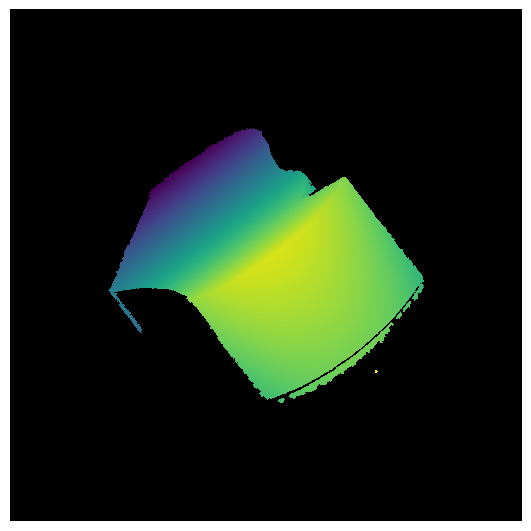

In [58]:
padded = pad_to_size(image, target_size=(512, 512), pad_value=0.)
display_depth_sharpness(
    [padded[::-1]],
    axes_size=(padded.shape[1], padded.shape[0]),
    dpi=100
)
plt.savefig('a.png', dpi=100)

In [37]:
display_depth_sharpness(
    [image[::-1]],
    axes_size=(image.shape[1], image.shape[0]),
    dpi=100
)
plt.savefig('b.png', dpi=100)

NameError: name 'image' is not defined

In [18]:
def reproject_image_to_points(
    image,
    pose: CameraPose,
    Kf: np.array,
    Ks: np.array,
    image_offset: Tuple[int, int],
):
    image_size = (
        image.shape[1] + image_offset[0], 
        image.shape[0] + image_offset[1])

#     x_mm = np.linspace(0, 2048 / s_x, 2048)
#     y_mm = np.linspace(0, 1536 / s_y, 1536)
    i = np.arange(image_offset[0], image_offset[0] + image.shape[1])
    j = np.arange(image_offset[1], image_offset[1] + image.shape[0])
    i, j = np.meshgrid(i, j)
    
    x_pixel = np.stack((i, j, np.ones_like(i))) #.reshape((3, -1)).T
    x_pixel = x_pixel[:, image != 0].T
    
    x_image = np.dot(
        np.linalg.inv(Ks),
        x_pixel.T).T
    x_image[:, 2] = image[image != 0].ravel()

    X_camera = np.dot(
        np.linalg.inv(Kf),
        x_image.T).T
    
    X = pose.camera_to_world(X_camera)
    
    return x_pixel, x_image, X_camera, X

In [1201]:
x_pixel_re, x_image_re, X_camera_re, X_re = reproject_image_to_points(image, pose, Kf, Ks, image_offset)

In [1202]:
display_sharpness(
    samples=X_camera_re, samples_color='z', samples_psize=0.5,
    sharp_vert=X_camera, sharpvert_color=0xcccccc, sharpvert_psize=0.5,
)

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  np.dtype(self.dtype).name))


Output()

In [166]:
from functools import partial
import h5py
import sharpf.utils.abc_utils.hdf5.io_struct as io


UnlabeledSLDepthMapIO = io.HDF5IO({
        'image': io.Float64('image'),
        'image_offset': io.Float64('image_offset'),
        'item_id': io.AsciiString('item_id'),
        'camera_extrinsics': io.Float64('camera_extrinsics'),
        'camera_intrinsics_f': io.Float64('camera_intrinsics_f'),
        'camera_intrinsics_s': io.Float64('camera_intrinsics_s'),
    },
    len_label='has_sharp',
    compression='lzf')


def save_depth_maps(patches, filename):
    # turn a list of dicts into a dict of torch tensors:
    # default_collate([{'a': 'str1', 'x': np.random.normal()}, {'a': 'str2', 'x': np.random.normal()}])
    # Out[26]: {'a': ['str1', 'str2'], 'x': tensor([0.4252, 0.1414], dtype=torch.float64)}
    collate_fn = partial(io.collate_mapping_with_io, io=UnlabeledSLDepthMapIO)
    patches = collate_fn(patches)

    with h5py.File(filename, 'w') as f:
        UnlabeledSLDepthMapIO.write(f, 'image', patches['image'].numpy())
        UnlabeledSLDepthMapIO.write(f, 'image_offset', patches['image_offset'].numpy())
        UnlabeledSLDepthMapIO.write(f, 'item_id', patches['item_id'])
        UnlabeledSLDepthMapIO.write(f, 'camera_extrinsics', patches['camera_extrinsics'].numpy())
        UnlabeledSLDepthMapIO.write(f, 'camera_intrinsics_f', patches['camera_intrinsics_f'].numpy())
        UnlabeledSLDepthMapIO.write(f, 'camera_intrinsics_s', patches['camera_intrinsics_s'].numpy())        


        
def rangevision_project_to_hdf5(
    input_dir: str,
    output_filename: str,
    camera='a',
    target_size=(512, 512)
):
    scans = sorted(glob(os.path.join(input_dir, 'scan_res_*')))
    ply_files = sorted(glob(os.path.join(input_dir, '*.ply')))
    
    patches = []
    for scan_dir, ply_file in tqdm(zip(scans, ply_files)):
        print(scan_dir)
        
        scan = trimesh.load(ply_file)
        
        params_by_name = read_calibration_params(
            os.path.join(scan_dir, 'Raw/impar{}01.txt'.format(camera)))

        angles = params_by_name['alf,om,kap']
        X0 = params_by_name['X0']
        f = params_by_name['f']
        s_x, s_y = params_by_name['m'] * 1e3
        o_x, o_y = params_by_name['b']

        pose = get_camera_extrinsic(angles, X0)
        Kf = get_camera_intrinsic_f(f)
        Ks = get_camera_intrinsic_s(s_x, s_y, o_x, o_y)

        X_camera, x_pixel, x_image, image, image_offset = project_to_camera(
            scan.vertices,
            pose, 
            Kf,
            Ks,
            image_size=(2048, 1536))
        padded = pad_to_size(image, target_size=target_size, pad_value=0.)
        
        patches.append({
            'image': padded,
            'image_offset': np.array(image_offset),
            'item_id': '__'.join([
                os.path.basename(input_dir),
                os.path.basename(scan_dir),
                os.path.basename(ply_file)]),
            'camera_extrinsics': pose.camera_to_world_4x4,
            'camera_intrinsics_f': Kf,
            'camera_intrinsics_s': Ks,
        })
        
    save_depth_maps(patches, output_filename)
    return patches


In [171]:
patches = rangevision_project_to_hdf5(
    '/data/abc/sharp_features_whole_models/20201112_40cm_hook/',
    '/data/abc/sharp_features_whole_models/20201112_40cm_hook/20201112_40cm_hook.hdf5',
)

0it [00:00, ?it/s]

/data/abc/sharp_features_whole_models/20201112_40cm_hook/scan_res_0024


1it [00:00,  1.12it/s]

Overwriting image_size with  (214, 234)
/data/abc/sharp_features_whole_models/20201112_40cm_hook/scan_res_0025


2it [00:01,  1.10it/s]

Overwriting image_size with  (215, 201)
/data/abc/sharp_features_whole_models/20201112_40cm_hook/scan_res_0026


3it [00:03,  1.06s/it]

Overwriting image_size with  (299, 196)
/data/abc/sharp_features_whole_models/20201112_40cm_hook/scan_res_0027


4it [00:04,  1.13s/it]

Overwriting image_size with  (241, 211)
/data/abc/sharp_features_whole_models/20201112_40cm_hook/scan_res_0028


5it [00:05,  1.22s/it]

Overwriting image_size with  (187, 275)
/data/abc/sharp_features_whole_models/20201112_40cm_hook/scan_res_0029


6it [00:07,  1.30s/it]

Overwriting image_size with  (179, 316)
/data/abc/sharp_features_whole_models/20201112_40cm_hook/scan_res_0030


7it [00:09,  1.39s/it]

Overwriting image_size with  (220, 307)
/data/abc/sharp_features_whole_models/20201112_40cm_hook/scan_res_0031


8it [00:10,  1.49s/it]

Overwriting image_size with  (213, 318)
/data/abc/sharp_features_whole_models/20201112_40cm_hook/scan_res_0032


9it [00:12,  1.48s/it]

Overwriting image_size with  (255, 294)
/data/abc/sharp_features_whole_models/20201112_40cm_hook/scan_res_0033


10it [00:13,  1.47s/it]

Overwriting image_size with  (305, 223)
/data/abc/sharp_features_whole_models/20201112_40cm_hook/scan_res_0034


11it [00:15,  1.55s/it]

Overwriting image_size with  (308, 232)
/data/abc/sharp_features_whole_models/20201112_40cm_hook/scan_res_0035


12it [00:16,  1.41s/it]

Overwriting image_size with  (312, 217)


In [144]:
images = [image for image in images]

In [145]:
images_display = [pad_to_size(image, target_size=(512, 512), pad_value=0.) for image in images]

In [146]:
yy, xx = np.where(images_display[0])

In [147]:
# X_camera, x_pixel, x_image, image, image_offset = project_to_camera(
#     scan.vertices,
#     pose, 
#     Kf,
#     Ks,
#     image_size=(2048, 1536))

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))


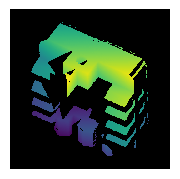

In [149]:
display_depth_sharpness(
    [images_display[0]],
    axes_size=(160, 160),
    ncols=1,
    dpi=100
)

In [150]:
images_display[0][np.min(yy):-np.min(yy), np.min(xx):-np.min(xx)]
x_pixel_re, x_image_re, X_camera_re, X_re = reproject_image_to_points(
    images[0],
    pose,
    Kf, 
    Ks,
    image_offsets[0]
)

In [151]:
display_sharpness(
    samples=scan.vertices,
    samples_color='z',
    samples_psize=0.1,
    sharp_vert=X_re,
    sharpvert_color=0xcccccc,
    sharpvert_psize=0.1
)

Output()

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))


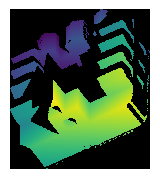

In [127]:
display_depth_sharpness(
    [images_display[0][np.min(yy):-np.min(yy), np.min(xx):-np.min(xx)]],
    axes_size=(160, 160),
    ncols=1,
    dpi=100
)

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))


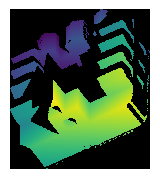

In [128]:
display_depth_sharpness(
    [images[0]],
    axes_size=(160, 160),
    ncols=1,
    dpi=100
)